In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import img_to_array
import tensorflow_hub as hub

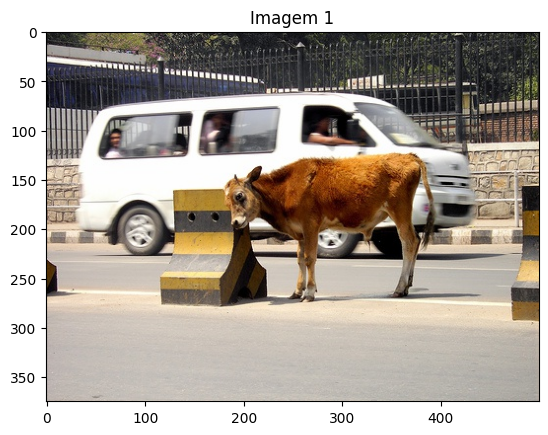

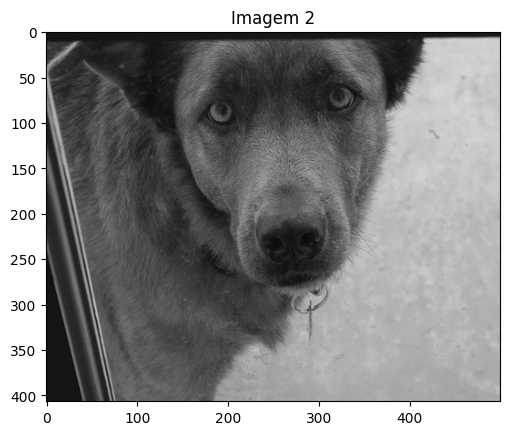

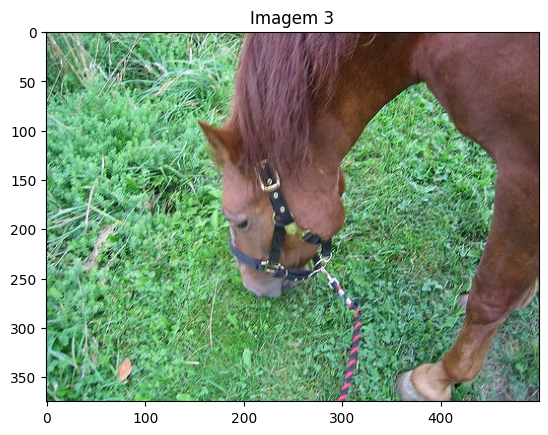

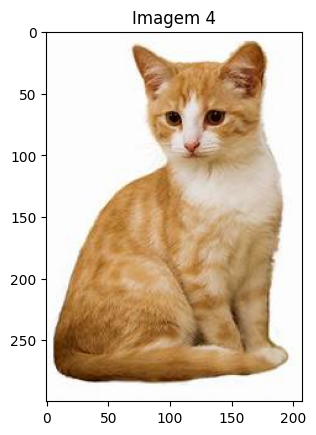

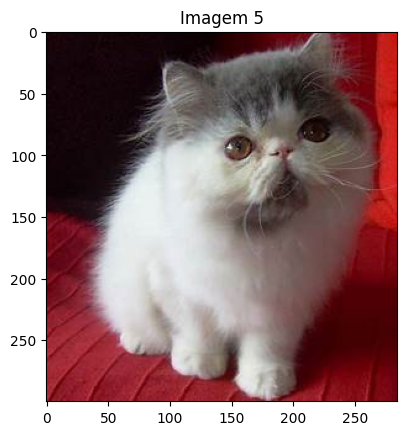

In [ ]:
image_folder = '/content/drive/MyDrive/images'

def load_and_display_images(folder, num_images=5):
    images = []
    for i, filename in enumerate(os.listdir(folder)):
        if i >= num_images:
            break
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            images.append(img)
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            plt.title(f"Imagem {i+1}")
            plt.show()

load_and_display_images(image_folder)

In [ ]:
model = MobileNetV2(weights='imagenet')

def is_cow(image):
    resized_image = cv2.resize(image, (224, 224))
    img_array = img_to_array(resized_image)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    predictions = model.predict(img_array)
    decoded_predictions = decode_predictions(predictions, top=1)
    for _, class_name, score in decoded_predictions[0]:
        if class_name in ['ox', 'cow'] and score > 0.5:
            return True
    return False

In [ ]:
def count_cows(folder):
    cow_images = []
    cow_count = 0
    total_images = 0
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            total_images += 1
            if is_cow(img):
                cow_count += 1
                cow_images.append(img)
    return cow_count, total_images, cow_images

cow_count, total_images, cow_images = count_cows(image_folder)
print(f'Total de imagens: {total_images}, Imagens de bovinos: {cow_count}')

1/1 [==============================] - 0s 67ms/step
Total de imagens: 4615, Imagens de bovinos: 172


In [ ]:
movenet_model = hub.load("https://tfhub.dev/google/movenet/singlepose/thunder/4")

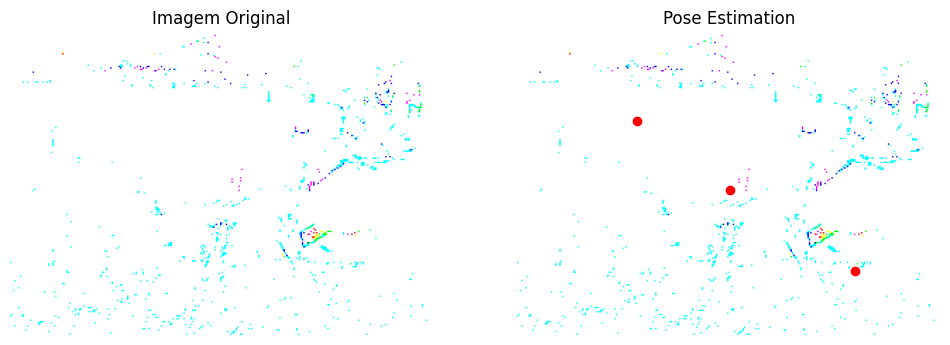

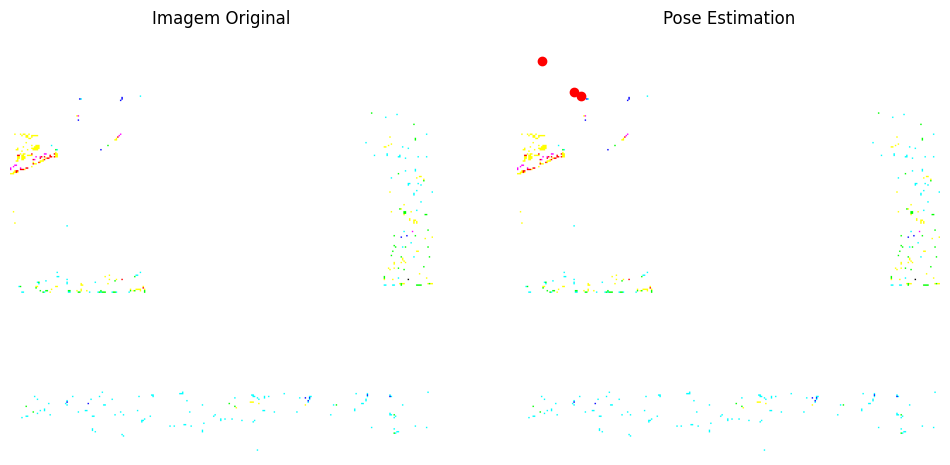

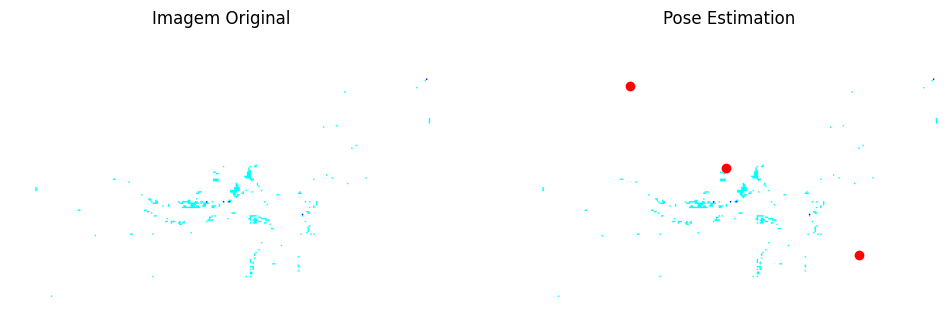

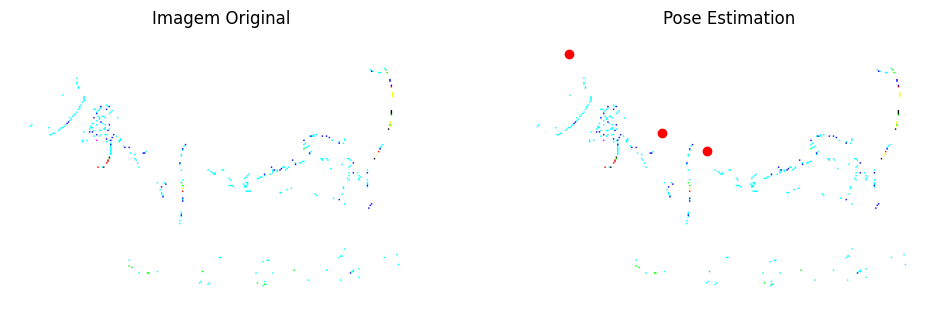

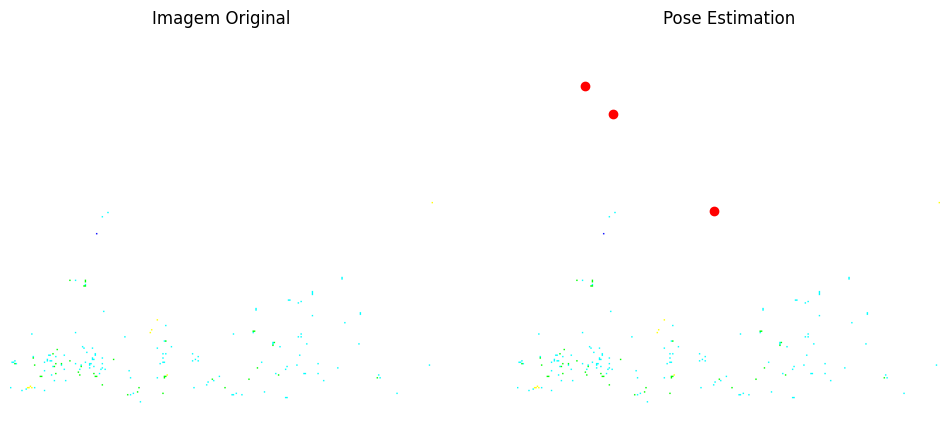

In [ ]:
def display_pose_estimation(image):
    # Redimensionar a imagem para 256x256 pixels e converter para float32
    input_image = tf.image.resize_with_pad(image, 256, 256)
    input_image = tf.cast(input_image, dtype=tf.int32)
    input_image = tf.expand_dims(input_image, axis=0)

    # Executar o modelo de pose estimation
    outputs = movenet_model.signatures['serving_default'](input_image)
    keypoints = outputs['output_0'][0][:, :2].numpy()  # Pegando apenas os pontos (y, x)

    # Criar a figura com dois subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Plotar a imagem original no primeiro subplot
    axs[0].imshow(cv2.cvtColor(image.numpy(), cv2.COLOR_BGR2RGB))
    axs[0].set_title("Imagem Original")
    axs[0].axis('off')

    # Plotar a imagem com pose estimation no segundo subplot
    axs[1].imshow(cv2.cvtColor(image.numpy(), cv2.COLOR_BGR2RGB))
    for ky, kx in keypoints:
        axs[1].plot(kx * image.shape[1], ky * image.shape[0], 'ro')
    axs[1].set_title("Pose Estimation")
    axs[1].axis('off')

    plt.show()

# Exibir pose estimation para 5 imagens de bovino
for i, img in enumerate(cow_images):
    if i >= 5:
        break
    img_tensor = tf.convert_to_tensor(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), dtype=tf.float32)
    display_pose_estimation(img_tensor)